In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Sun Mar 21 13:37:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
root_path = "/content/drive/MyDrive/Data/Dogs vs Cats"
train_path = "/content/drive/MyDrive/Data/Dogs vs Cats/train"
test_path = "/content/drive/MyDrive/Data/Dogs vs Cats/test"

In [ ]:
"""
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Data/Kaggle API Token/"

root_path = "/content/drive/MyDrive/Data/Dogs vs Cats"
os.chdir(root_path)

!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition
!unzip train.zip  && rm train.zip
!unzip test.zip  && rm test.zip

|"""

'\nimport os\nos.environ[\'KAGGLE_CONFIG_DIR\'] = "/content/drive/MyDrive/Data/Kaggle API Token/"\n\nroot_path = "/content/drive/MyDrive/Data/Dogs vs Cats"\nos.chdir(root_path)\n\n!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition\n!unzip train.zip  && rm train.zip\n!unzip test.zip  && rm test.zip\n\n|'

In [ ]:
import pandas as od
import numpy as np
import cv2
from tqdm import tqdm
from random import shuffle

img_size = 224

In [ ]:
def label(img):
  x = img.split('.')[0]
  if x=='dog': return [0,1]
  elif x == 'cat': return [1,0]
def id(img):
  id = img.split('.')[1]
  return id
def test_id(img):
  id = img.split('.')[0]
  return id

In [ ]:
def create_train_data():
  train_data = []

  for img in tqdm(os.listdir(train_path)):
    lab = label(img)
    id_num = id(img)

    path = os.path.join(train_path,img)
    image =  cv2.resize(cv2.imread(path,cv2.IMREAD_COLOR),(img_size,img_size))
    train_data.append([np.array(image),np.array(lab),np.array(id_num)])
  shuffle(train_data)
  np.save(os.path.join(root_path,'train_data.npy'),train_data)
  return train_data

In [ ]:
#train_data=create_train_data()
train_data=np.load(os.path.join(root_path,'train_data.npy'),allow_pickle=True)

In [ ]:
def create_test_data():
  test_data = []

  for img in tqdm(os.listdir(test_path)):
    id_num = test_id(img)

    path = os.path.join(test_path,img)
    image = cv2.resize(cv2.imread(path,cv2.IMREAD_COLOR),(img_size,img_size))
    test_data.append([np.array(image),np.array(id_num)])
  np.save(os.path.join(root_path,'test_data.npy'),test_data)
  return test_data

In [ ]:
X_train = np.array([i[0] for i in train_data[:-2000]]).reshape(-1,img_size,img_size,3)
y_train = np.array([i[1] for i in train_data[:-2000]])

X_test = np.array([i[0] for i in train_data[-2000:]]).reshape(-1,img_size,img_size,3)
y_test = np.array([i[1] for i in train_data[-2000:]])

In [ ]:
print(X_train.shape)
print(y_train.shape)

(23000, 224, 224, 3)
(23000, 2)


#Model-01

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D, BatchNormalization
import pickle
import tensorflow as tf
from tensorflow import keras

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    patience = 15,
    min_delta = 0.001,
    restore_best_weights = True
)

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf

feature_extractor = "https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor,input_shape=(img_size,img_size,3))
feature_extractor_layer.tranable = False

model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2,activation='softmax')
])

In [ ]:
if os.path.exists(os.path.join(root_path,"model-01")):
  model = keras.models.load_model(os.path.join(root_path,"model-01"))
if not os.path.exists(os.path.join(root_path,"model-01")):
  model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
  history = model.fit(X_train,y_train,epochs=100,batch_size=128,validation_data=(X_test,y_test),callbacks=[early_stopping])
  model.save(os.path.join(root_path,"model-01"))
  with open(os.path.join(root_path,"model-01-history"),'wb') as file_pi:
    pickle.dump(history.history,file_pi)

In [ ]:
_, eval_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"In train evaluation: {eval_acc}\n")
_, eval_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Best accuracy in evaluation: {eval_acc}\n")

In train evaluation: 0.6245217323303223

Best accuracy in evaluation: 0.621999979019165



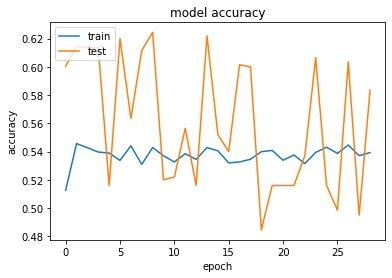

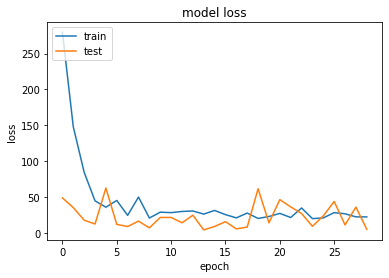

In [ ]:
history = pickle.load(open(os.path.join(root_path,"model-01-history"), "rb"))
import matplotlib.pyplot as plt

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Model-02

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf

feature_extractor = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor,input_shape=(img_size,img_size,3))
feature_extractor_layer.tranable = False

model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2,activation='softmax')
])

In [ ]:
if os.path.exists(os.path.join(root_path,"model-02")):
  model = keras.models.load_model(os.path.join(root_path,"model-02"))
if not os.path.exists(os.path.join(root_path,"model-02")):
  model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
  history = model.fit(X_train,y_train,epochs=100,batch_size=128,validation_data=(X_test,y_test),callbacks=[early_stopping])
  model.save(os.path.join(root_path,"model-02")) 
  with open(os.path.join(root_path,"model-02-history"),'wb') as file_pi:
    pickle.dump(history.history,file_pi)

In [ ]:
_, eval_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"In train evaluation: {eval_acc}\n")
_, eval_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Best accuracy in evaluation: {eval_acc}\n")

In train evaluation: 0.6954782605171204

Best accuracy in evaluation: 0.6880000233650208



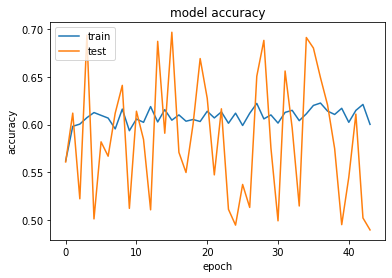

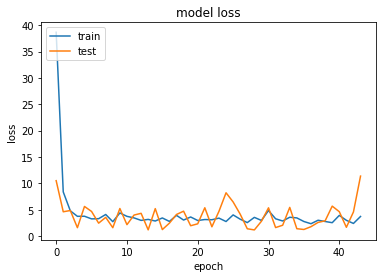

In [ ]:
history = pickle.load(open(os.path.join(root_path,"model-02-history"), "rb"))
import matplotlib.pyplot as plt

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Model-03

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf

feature_extractor = "https://tfhub.dev/google/inaturalist/inception_v3/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor,input_shape=(img_size,img_size,3))
feature_extractor_layer.tranable = False

model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2,activation='softmax')
])

In [ ]:
if os.path.exists(os.path.join(root_path,"model-03")):
  model = keras.models.load_model(os.path.join(root_path,"model-03"))
if not os.path.exists(os.path.join(root_path,"model-03")):
  model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
  history = model.fit(X_train,y_train,epochs=100,batch_size=128,validation_data=(X_test,y_test),callbacks=[early_stopping])
  model.save(os.path.join(root_path,"model-03"))
  with open(os.path.join(root_path,"model-03-history"),'wb') as file_pi:
    pickle.dump(history.history,file_pi)

In [ ]:
_, eval_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"In train evaluation: {eval_acc}\n")
_, eval_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Best accuracy in evaluation: {eval_acc}\n")

In train evaluation: 0.7229565382003784

Best accuracy in evaluation: 0.715499997138977



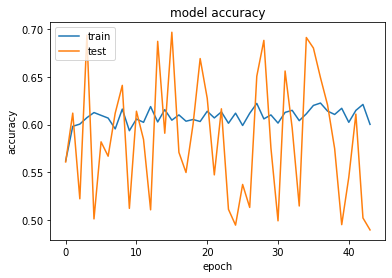

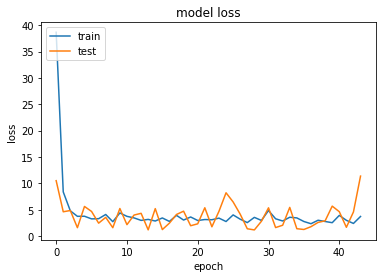

In [ ]:
history = pickle.load(open(os.path.join(root_path,"model-02-history"), "rb"))
import matplotlib.pyplot as plt

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Model-04

In [ ]:
from keras.applications import vgg16

feature_extractor_layer = vgg16.VGG16(weights='imagenet')
feature_extractor_layer.tranable = False

model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2,activation='softmax')
])

In [ ]:
if os.path.exists(os.path.join(root_path,"model-04")):
  model = keras.models.load_model(os.path.join(root_path,"model-04"))
if not os.path.exists(os.path.join(root_path,"model-04")):
  model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
  history = model.fit(X_train,y_train,epochs=100,batch_size=128,validation_data=(X_test,y_test),callbacks=[early_stopping])
  model.save(os.path.join(root_path,"model-04"))
  with open(os.path.join(root_path,"model-04-history"),'wb') as file_pi:
    pickle.dump(history.history,file_pi)

Epoch 1/100
180/180 [==============================] - 340s 2s/step - loss: 0.6934 - accuracy: 0.5005 - val_loss: 0.6930 - val_accuracy: 0.5160
Epoch 2/100
180/180 [==============================] - 316s 2s/step - loss: 0.6932 - accuracy: 0.4999 - val_loss: 0.6933 - val_accuracy: 0.4840
Epoch 3/100
180/180 [==============================] - 316s 2s/step - loss: 0.6932 - accuracy: 0.5035 - val_loss: 0.6933 - val_accuracy: 0.4840
Epoch 4/100
180/180 [==============================] - 316s 2s/step - loss: 0.6932 - accuracy: 0.4975 - val_loss: 0.6935 - val_accuracy: 0.4840
Epoch 5/100
180/180 [==============================] - 316s 2s/step - loss: 0.6933 - accuracy: 0.4961 - val_loss: 0.6935 - val_accuracy: 0.4840
Epoch 6/100
180/180 [==============================] - 316s 2s/step - loss: 0.6932 - accuracy: 0.4984 - val_loss: 0.6934 - val_accuracy: 0.4840
Epoch 7/100
180/180 [==============================] - 315s 2s/step - loss: 0.6932 - accuracy: 0.4969 - val_loss: 0.6932 - val_accuracy:

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/Dogs vs Cats/model-04/assets


In [ ]:
_, eval_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"In train evaluation: {eval_acc}\n")
_, eval_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Best accuracy in evaluation: {eval_acc}\n")

In train evaluation: 0.49860870838165283

Best accuracy in evaluation: 0.515999972820282



#Model-05

In [ ]:
from keras.applications import vgg19

feature_extractor_layer = vgg19.VGG19(weights='imagenet')
feature_extractor_layer.tranable = False

model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2,activation='softmax')
])

In [ ]:
if os.path.exists(os.path.join(root_path,"model-05")):
  model = keras.models.load_model(os.path.join(root_path,"model-05"))
if not os.path.exists(os.path.join(root_path,"model-05")):
  model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
  history = model.fit(X_train,y_train,epochs=100,batch_size=128,validation_data=(X_test,y_test),callbacks=[early_stopping])
  model.save(os.path.join(root_path,"model-05"))
  with open(os.path.join(root_path,"model-05-history"),'wb') as file_pi:
    pickle.dump(history.history,file_pi)

Epoch 1/100
180/180 [==============================] - 385s 2s/step - loss: 0.6941 - accuracy: 0.4965 - val_loss: 0.6931 - val_accuracy: 0.5160
Epoch 2/100
180/180 [==============================] - 357s 2s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.4840
Epoch 3/100
180/180 [==============================] - 363s 2s/step - loss: 0.6934 - accuracy: 0.4951 - val_loss: 0.6935 - val_accuracy: 0.4840
Epoch 4/100
180/180 [==============================] - 362s 2s/step - loss: 0.6932 - accuracy: 0.4986 - val_loss: 0.6936 - val_accuracy: 0.4840
Epoch 5/100
180/180 [==============================] - 360s 2s/step - loss: 0.6930 - accuracy: 0.5075 - val_loss: 0.6933 - val_accuracy: 0.4840
Epoch 6/100
180/180 [==============================] - 374s 2s/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6935 - val_accuracy: 0.4840
Epoch 7/100
180/180 [==============================] - 356s 2s/step - loss: 0.6933 - accuracy: 0.4975 - val_loss: 0.6935 - val_accuracy:

In [ ]:
_, eval_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"In train evaluation: {eval_acc}\n")
_, eval_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Best accuracy in evaluation: {eval_acc}\n")

In train evaluation: 0.49860870838165283

Best accuracy in evaluation: 0.515999972820282



#Test

In [ ]:
"""
#test_data = create_test_data()
test_data = np.load(os.path.join(root_path,'test_data.npy'),allow_pickle=True)
test_image = np.array([i[0] for i in test_data]).reshape(-1,img_size,img_size,3)
test_id = np.array([i[1] for i in test_data])

import pandas as pd

result = model.predict(test_image)
result = result[:,1]

submission = pd.DataFrame({
        "id": test_id,
        "label": result
    })
submission.to_csv('submission.csv', index=False)
submission.head()
"""

'\n#test_data = create_test_data()\ntest_data = np.load(os.path.join(root_path,\'test_data.npy\'),allow_pickle=True)\ntest_image = np.array([i[0] for i in test_data]).reshape(-1,img_size,img_size,3)\ntest_id = np.array([i[1] for i in test_data])\n\nimport pandas as pd\n\nresult = model.predict(test_image)\nresult = result[:,1]\n\nsubmission = pd.DataFrame({\n        "id": test_id,\n        "label": result\n    })\nsubmission.to_csv(\'submission.csv\', index=False)\nsubmission.head()\n'